# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.4481],
         [1.0209]]),
 tensor([[1.0000e+00, 4.4808e-01, 1.0039e-01, 1.4994e-02, 1.6797e-03, 1.5053e-04,
          1.1241e-05, 7.1959e-07, 4.0305e-08, 2.0066e-09, 8.9915e-11, 3.6627e-12,
          1.3676e-13, 4.7140e-15, 1.5088e-16, 4.5070e-18, 1.2622e-19, 3.3269e-21,
          8.2818e-23, 1.9531e-24],
         [1.0000e+00, 1.0209e+00, 5.2108e-01, 1.7732e-01, 4.5254e-02, 9.2396e-03,
          1.5721e-03, 2.2926e-04, 2.9256e-05, 3.3185e-06, 3.3877e-07, 3.1440e-08,
          2.6746e-09, 2.1003e-10, 1.5315e-11, 1.0423e-12, 6.6504e-14, 3.9936e-15,
          2.2650e-16, 1.2170e-17]]),
 tensor([5.2462, 5.6217]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 4.9925513  1.192435  -3.3967226  5.592224 ]]


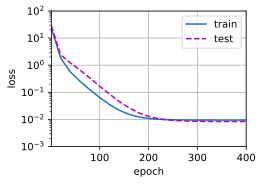

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[3.4030175 3.478811 ]]


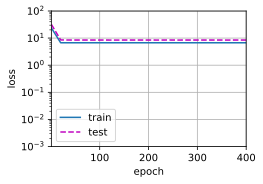

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 4.9690418e+00  1.2824879e+00 -3.2682838e+00  5.1069427e+00
  -3.6502776e-01  1.4870459e+00  1.6816342e-04  8.4213972e-02
  -5.8146473e-02  7.1264967e-02  4.7889385e-02 -2.0723081e-01
   6.2527008e-02  3.4208562e-02 -1.4951968e-01  1.9339839e-01
  -1.9543761e-01 -7.1054682e-02  3.6714438e-02 -1.3841800e-01]]


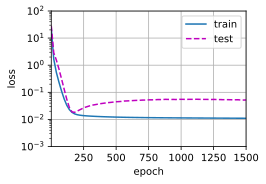

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)